In [1]:
from pref_voting.dominance_axioms import condorcet_winner, condorcet_loser, pareto_dominance
from pref_voting.profiles import _find_updated_profile
from pref_voting.pairwise_profiles import *
from pref_voting.voting_methods import *
from pref_voting.generate_profiles import *
from pref_voting.voting_methods_registry import voting_methods
from pref_voting.generate_weighted_majority_graphs import *
from pref_voting.helper import *
from pref_voting.mappings import *  
from tqdm.notebook import tqdm
from itertools import permutations
from pref_voting.axioms import *

+---+---+---+---+---+
| 4 | 1 | 9 | 8 | 5 |
+---+---+---+---+---+
| a | b | c | a | c |
| c | a | a | b | b |
| b | c | b | c | a |
+---+---+---+---+---+


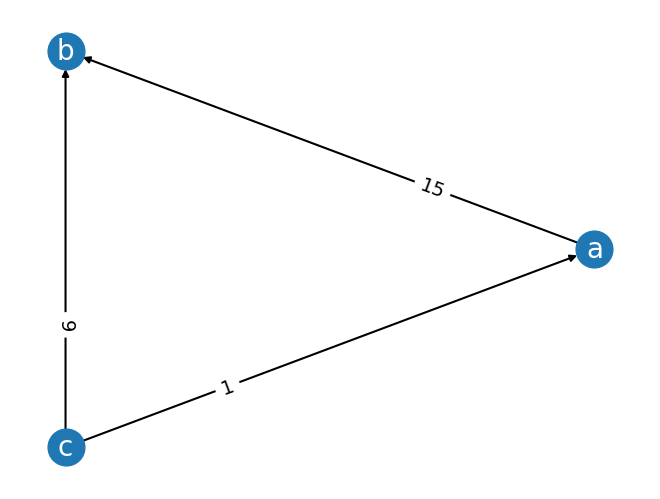

In [4]:
a=0
b=1
c=2
d=3
prof = Profile([
    [a, c, b],
    [b, a, c],
    [c, a, b], 
    [a, b, c], 
    [c, b, a]
], 
rcounts=[4, 1, 9, 8, 5],
cmap = {a: 'a', b: 'b', c: 'c'})

prof.display()

prof.display_margin_graph()

+---+---+---+---+---+
| 4 | 1 | 9 | 8 | 5 |
+---+---+---+---+---+
| a | b | c | a | d |
| c | a | d | b | c |
| b | d | a | d | b |
| d | c | b | c | a |
+---+---+---+---+---+


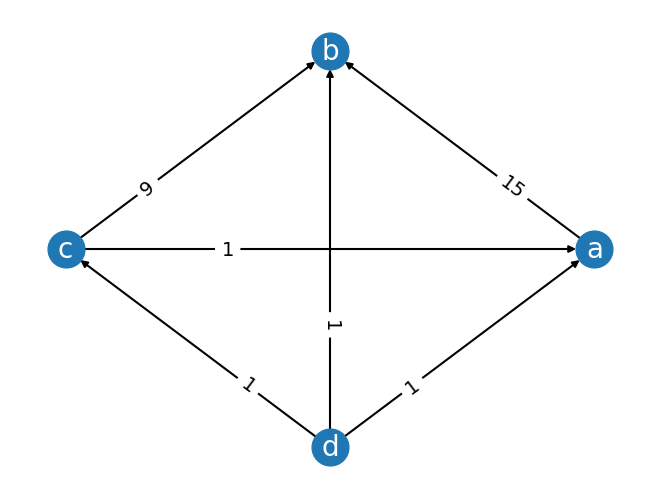

In [5]:
prof = Profile([
    [a, c, b, d],
    [b, a, d, c],
    [c, d, a, b], 
    [a, b, d, c], 
    [d, c, b, a]
], 
rcounts=[4, 1, 9, 8, 5],
cmap = {a: 'a', b: 'b', c: 'c', d: 'd'})

prof.display()

prof.display_margin_graph()

In [2]:
mg = MarginGraph(
    [0, 1, 2, 3], 
    [
        (0, 1, 10), 
        (0, 2, 2), 
        (1, 3, 4), 
        (2, 1, 6), 
        (2, 3, 8), 
        (3, 0, 4)]
        )

rp_defeats = ranked_pairs_defeats(mg)

print(rp_defeats)

[<networkx.classes.digraph.DiGraph object at 0x2c2a4b450>, <networkx.classes.digraph.DiGraph object at 0x2c2a4b410>]


In [ ]:
prof = ProfileWithTies([
    {0: 1, 2: 1, 1: 2, 3: 2}, 
    {3: 1, 0: 2, 1: 3, 2: 4}, 
    {2: 1, 1: 1, 3: 1}, 
    {3: 1, 0: 2, 1: 3, 2: 4}, 
    {1: 1, 2: 2}, 
    {}, 
    {3: 2, 1: 3, 2: 4}], 
    rcounts=[1, 1, 1, 1, 1, 1, 1], 
    cmap={0: 'a', 1: 'b', 2: 'c', 3: 'd'})

prof = ProfileWithTies([{}], rcounts=[100], cmap={0: 'a', 1: 'b', 2: 'c', 3: 'd'})
prof.display()

print(prof.to_latex())

In [5]:
def to_quarto(prof, cmap = None, curr_cands = None):

    cmap = cmap if cmap is not None else prof.cmap
    rankings = prof._rankings if curr_cands is None else _find_updated_profile(prof._rankings, np.array([c for c in prof.candidates if c not in curr_cands]), len(prof.candidates))
    
    cs = 'c' * len(prof._rcounts)
    
    latex_str = "\\begin{array}{" + str(cs) + "}\n"
    latex_str += " & ".join([f"{rc}" for rc in prof._rcounts]) + "\\\\\hline \n"
    latex_str +=  "\\\\ \n".join([" & ".join([f"{cmap[c]}" for c in cs])  for cs in rankings.transpose()])
    latex_str += "\n\\end{array}"
    
    return latex_str


In [ ]:
from itertools import combinations

for t in range(10): 

    num_cands = random.choice([3, 4, 4, 4])

    prof = generate_profile(num_cands, 50)

    cmap = {0: 'a', 1: 'b', 2: 'c', 3: 'd'}

    num_rankings = random.choice([3, 4, 5, 6])
    prof_smaller = Profile(prof.anonymize().ranking_types[0:num_rankings], list(prof.anonymize()._rcounts)[0:num_rankings], cmap=cmap)

    prof_smaller.display()

    prof_smaller.display_margin_graph()
    print(to_quarto(prof_smaller, cmap=cmap))

    for c1, c2 in combinations(prof_smaller.candidates, 2):
        print(f"* The margin of ${cmap[c1]}$ over ${cmap[c2]}$ is ${prof_smaller.support(c1, c2)} - {prof_smaller.support(c2, c1)} = {prof_smaller.margin(c1, c2)}$")
        print(f"* The margin of ${cmap[c2]}$ over ${cmap[c1]}$ is ${prof_smaller.support(c2, c1)} - {prof_smaller.support(c1, c2)} = {prof_smaller.margin(c2, c1)}$")

    print("\nThe margin graph is:")
    print(prof_smaller.margin_graph().to_latex(cmap=cmap))

print("\n\n--------\n\n")

In [ ]:
mg = generate_margin_graph(5)
mg.display()
mg.debord_profile().display()
mg.minimal_profile().display()

In [8]:
num_cands = 4
num_voters = 5
a=0
b=1
c=2
d=3
e=4
cmap = {a: 'a', b: 'b', c: 'c', d: 'd', e: 'e'}

num_trials = 1000000

for t in range(num_trials): 
    prof = generate_profile(num_cands, num_voters)
    rankings = prof.rankings

    if len(rankings) == 5:
        v1_ranking = rankings[0]
        borda_ws = borda(prof)
        if len(borda_ws) == 2 and  v1_ranking[0] in borda_ws and v1_ranking[3] in borda_ws:

            margins = list(set([prof.margin(c1, c2) for c1 in prof.candidates for c2 in prof.candidates if prof.majority_prefers(c1, c2)]))

            if len(margins) >= 3: 
                for new_ranking in permutations(prof.candidates):
                    new_prof = Profile([new_ranking] + rankings[1:])
                    new_borda_ws = borda(new_prof)
                    if (len(new_borda_ws)==2 and v1_ranking[1] in new_borda_ws and v1_ranking[2] in new_borda_ws) or (len(new_borda_ws)==1 and v1_ranking[1] in new_borda_ws):
                        print(margins)
                        print(prof)
                        print(prof.to_latex(cmap=cmap))
                        print(new_ranking)
                        print(new_prof.to_latex(cmap=cmap))
                        break


In [ ]:
num_cands = 5
num_voters = 4

a=0
b=1
c=2
d=3
e=4
cmap = {a: 'a', b: 'b', c: 'c', d: 'd', e: 'e'}


for _prof in enumerate_anon_profile(num_cands, num_voters):
    prof = _prof.anonymize()
    rankings = prof.rankings

    if True or len(rankings) == 5:
        v1_ranking = rankings[0]
        borda_ws = borda(prof)
        if len(borda_ws) == 2 and  v1_ranking[0] in borda_ws and v1_ranking[4] in borda_ws:
        # if len(borda_ws) == 1 and  v1_ranking[1] in borda_ws:

            margins = list(set([prof.margin(c1, c2) for c1 in prof.candidates for c2 in prof.candidates if prof.majority_prefers(c1, c2)]))

            if len(margins) >= 2: 
                found_it = False
                for new_ranking in permutations(prof.candidates):
                    new_prof = Profile([new_ranking] + rankings[1:])
                    new_borda_ws = borda(new_prof)
                    # if (len(new_borda_ws)==2 and v1_ranking[1] in new_borda_ws and v1_ranking[2] in new_borda_ws):
                    if (len(new_borda_ws)==2 and v1_ranking[1] in new_borda_ws and v1_ranking[2] in new_borda_ws) or (len(new_borda_ws)==2 and v1_ranking[2] in new_borda_ws and v1_ranking[3] in new_borda_ws):
                    # if (len(new_borda_ws)==2 and v1_ranking[0] in new_borda_ws and v1_ranking[2] in new_borda_ws) or (len(new_borda_ws)==2 and v1_ranking[0] in new_borda_ws and v1_ranking[3] in new_borda_ws):
                        print(margins)
                        print(prof)
                        print(borda_ws)
                        print(prof.to_latex(cmap=cmap))
                        print(new_ranking)
                        print(new_borda_ws)
                        print(new_prof.to_latex(cmap=cmap))
                        found_it = False
                        break
            if found_it:
                break

In [ ]:
a=0
b=1
c=2
d=3
cmap = {a: 'a', b: 'b', c: 'c', d: 'd'}
orig_prof = Profile([
    [c, b, a, d], 
    [c, b, d, a], 
    [c, b, d, a], 
    [d, b, a, c],
    [d, b, a, c],
], cmap=cmap)
orig_prof.display()
    
mg = orig_prof.margin_graph()
mg.display()
print(mg.to_latex())

In [ ]:
a=0
b=1
c=2
d=3
cmap = {a: 'a', b: 'b', c: 'c', d: 'd'}
orig_prof = Profile([
    [c, b, a, d], 
    [c, b, d, a], 
    [c, b, d, a], 
    [d, b, a, c],
    [d, b, a, c],
], cmap=cmap)
orig_prof.display()

borda_ws = borda(orig_prof)
print(borda_ws)

for t in range(20): 
    _prof = generate_profile(4, 5)
    rankings = list(_prof.rankings)  
    if len(rankings) == 5: 
        prof = Profile([
            [c, b, a, d]
        ] + rankings[1:], cmap=cmap)
        new_borda_ws = borda(prof)
        if borda_ws == new_borda_ws:
            print('Match')
            print(prof)
            print(prof.to_latex())  

            print("\n--------\n")

In [ ]:
for t in range(100): 
    _prof = generate_profile(4, 5)
    rankings = list(_prof.rankings)  
    if len(rankings) == 5: 
        prof = Profile([
            [c, b, a, d]
        ] + rankings[1:], cmap=cmap)
        maj_g = prof.majority_graph()
        orig_maj_g = orig_prof.majority_graph()
        if maj_g == orig_maj_g:
            print('Match')
            maj_g.display()
            print(prof.to_latex())  
            print("\n-------\n")

In [ ]:
a=0
b=1
c=2
d=3
cmap = {a: 'a', b: 'b', c: 'c', d: 'd'}
orig_prof = Profile([
    [c, b, a, d], 
    [d, b, a, c], 
    [b, c, a, d],
    [b, d, a, c],
    [b, c, a, d]
], cmap=cmap)

print(orig_prof.to_latex())
orig_prof.display()
    
mg = orig_prof.margin_graph()
mg.display()
print(mg.to_latex())

In [ ]:
for t in range(100000): 
    _prof = generate_profile(4, 5)
    rankings = list(_prof.rankings)  
    if True or len(rankings) == 5: 
        prof = Profile([
            [c, b, a, d]
        ] + rankings[1:], cmap=cmap)
        mg = prof.margin_graph()
        orig_maj_g = orig_prof.margin_graph()
        if mg == orig_maj_g:
            print('Match')
            mg.display()
            print(prof.to_latex())  

            print("\n----------\n")

In [2]:
import pickle

In [ ]:
def _revealed_weak_preference(c1, c2, menu, choice): 
    """Returns the revealed weak preference of a menu of choices. 
    """

    return c1 in menu and c2 in menu and c1 in choice

def _revealed_strict_preference(c1, c2, menu, choice): 
    """Returns the revealed strict preference of a menu of choices. 

    """

    return _revealed_weak_preference(c1, c2, menu, choice) and not _revealed_weak_preference(c2, c1, menu, choice)

def _revealed_indifference(c1, c2, menu, choice): 
    """Returns the revealed indifference of a menu of choices. 

    """

    return _revealed_weak_preference(c1, c2, menu, choice) and  _revealed_weak_preference(c2, c1, menu, choice)

print( {1, 2}, {1, 2})
print(_revealed_weak_preference(1, 2, {1, 2}, {1, 2}))
print(_revealed_weak_preference(2, 1, {1, 2}, {1, 2}))

print(_revealed_strict_preference(1, 2, {1, 2}, {1, 2}))
print(_revealed_strict_preference(2, 1, {1, 2}, {1, 2}))
print(_revealed_indifference(1, 2, {1, 2}, {1, 2}))
print(_revealed_indifference(2, 1, {1, 2}, {1, 2}))

print( {1, 2}, {1})
print(_revealed_weak_preference(1, 2, {1, 2}, {1}))
print(_revealed_weak_preference(2, 1, {1, 2}, {1}))
print(_revealed_strict_preference(1, 2, {1, 2}, {1}))
print(_revealed_strict_preference(2, 1, {1, 2}, {1}))
print(_revealed_indifference(1, 2, {1, 2}, {1}))
print(_revealed_indifference(2, 1, {1, 2}, {1}))



In [ ]:
comparisons1 = [({"A", "B"}, {"A"}), ({"A", "C"}, {"C"}), ({"B", "C"}, {"B"})]
comparisons2 = [({"A", "B"}, {"B"}), ({"A", "C"}, {"A"}), ({"B", "C"}, {"C"})]
pprof = PairwiseProfile([PairwiseComparisons(comparisons1), PairwiseComparisons(comparisons2)], rcounts=[3,2])

pprof.display()

pprof.margin_graph().display()

In [ ]:
_pcomps = [(0, 1), (2, 1), ({0, 2}, {0, 2})]
pcomps = PairwiseComparisons(_pcomps)
print(pcomps.is_coherent())
pcomps.display()
print(pcomps)
print("pcomps.weak_preference(0, 1)", pcomps.weak_preference(0, 1))
print("pcomps.weak_preference(1, 0)", pcomps.weak_preference(1, 0))
print("pcomps.strict_preference(0, 1)", pcomps.strict_preference(0, 1))
print("pcomps.strict_preference(1, 0)", pcomps.strict_preference(1, 0))
print("pcomps.indifference(0, 1)", pcomps.indifference(0, 1))   
print("pcomps.indifference(1, 0)", pcomps.indifference(1, 0))

print("pcomps.weak_preference(0, 2)", pcomps.weak_preference(0, 2))
print("pcomps.weak_preference(2, 0)", pcomps.weak_preference(2, 0))
print("pcomps.strict_preference(0, 2)", pcomps.strict_preference(0, 2))
print("pcomps.strict_preference(2, 0)", pcomps.strict_preference(2, 0))
print("pcomps.indifference(0, 2)", pcomps.indifference(0, 2))   
print("pcomps.indifference(2, 0)", pcomps.indifference(2, 0))


print("pcomps.weak_preference(3, 4)", pcomps.weak_preference(3, 4))
print("pcomps.strict_preference(3, 4)", pcomps.strict_preference(3, 4))
print("pcomps.indifference(3, 4)", pcomps.indifference(3, 4))   

print("pcomps.has_comparison(0, 1)", pcomps.has_comparison(0, 1))
print("pcomps.has_comparison(1, 0)", pcomps.has_comparison(1, 0))
print("pcomps.has_comparison(0, 2)", pcomps.has_comparison(0, 2))
print("pcomps.has_comparison(2, 0)", pcomps.has_comparison(2, 0))
print("pcomps.has_comparison(3, 4)", pcomps.has_comparison(3, 4))
print("pcomps.has_comparison(2, 4)", pcomps.has_comparison(2, 4))


In [ ]:
pprof = PairwiseProfile([
    [[{0, 1}, {1}], (3, 2)], 
    [[{0, 2}, {2, 0}], [{0, 1}, {1}]]], 
    rcounts=[3, 2])

print(pprof)

pprof.display()
print(pprof.candidates)
print(pprof._pairwise_comparisons)
print(pprof._tally)
for c in pprof.candidates:
    for d in pprof.candidates:
        print(f'margin({c}, {d}) = {pprof.margin(c,d)}') 

print(pprof.condorcet_winner())

print(pprof.condorcet_loser())  
pprof.margin_graph().display()

split_cycle.display(pprof.margin_graph())

bradley_terry.display(pprof)

In [ ]:
violations = superior_voting.get_violation_witness("condorcet_winner")

for prof_type, prof in violations.items():
    if prof is not None:
        print(prof_type)
        print(prof)
        condorcet_winner.has_violation(prof, superior_voting, verbose=True)
    

In [ ]:
for vm in voting_methods.filter(violates=["condorcet_winner"], election_types=[ElectionTypes.PROFILE]):
    print(vm)

In [ ]:
for vm in voting_methods: 
    print(vm)
    elections = vm.get_violation_witness("condorcet_winner")
    for prof_type, prof in elections.items():
        if prof is not None:
            print(prof_type)
            condorcet_winner.has_violation(prof, vm, verbose=True)

In [ ]:
for vm in voting_methods:
    print(vm.__name__)
    print(vm.name)
    print(vm.properties.items())
    print(vm.get_properties())
    print

In [ ]:
print(axioms_dict)

In [ ]:
prof = generate_profile(5, 10)
prof.display()

print(prof.margin(0, 4))

pickle.dump(prof, open("profile.pkl", "wb"))
prof = pickle.load(open("profile.pkl", "rb"))
prof.display()

print(prof.margin(0, 4))


for vm in voting_methods:
    print(vm.name)
    if ElectionTypes.PROFILE in vm.input_types:
        print(vm(prof))


In [ ]:
r = [2, 0, 5, 4, 3, 1]
u = Utility.from_linear_ranking(r, seed=42)
print(u)
u.ranking().to_linear()


In [ ]:
prof = generate_profile(3, 2, seed=42)

prof.display()

uprof = prof.to_utility_profile()

uprof.display()

uprof.to_ranking_profile().to_linear_profile().display()


In [ ]:
rng = np.random.default_rng(42)
        
utilities = sorted(rng.random(size=6), reverse=True)
print(utilities)


In [ ]:
prof = ProfileWithTies([
    {'a': 1, 'b': 2, 'c': 3},
    {'a': 2, 'b': 1, 'c': 3},
    {'a': 3, 'b': 2, 'c': 1},
    {'a': 3},
    {'a': 2, 'b': 3, 'c': 1},
    {'a': 1, 'b': 3},
])

prof.display()

split_cycle.display(prof)
split_cycle.display(prof, algorithm='basic_parallel')

split_cycle.display(prof, curr_cands = ['b', 'c'])

split_cycle.display(prof, algorithm='basic_parallel', curr_cands = ['b', 'c'])

In [ ]:

for t in tqdm(range(1000)): 

    prof = generate_profile(random.choice([4, 5, 10, 15]),random.choice([5, 10, 100, 1001]))
    sc_ws = split_cycle(prof)
    sc_ws_parallel = split_cycle(prof, algorithm='basic_parallel')

    if sc_ws != sc_ws_parallel:
        print(prof)
        print(sc_ws)
        print(sc_ws_parallel)
        print("Error")
        break

    sc_ws = split_cycle(prof, curr_cands = [1, 2, 3])
    sc_ws_parallel = split_cycle(prof, curr_cands = [1, 2, 3], algorithm='basic_parallel')

    if sc_ws != sc_ws_parallel:
        print(prof)
        print(sc_ws)
        print(sc_ws_parallel)
        print("Error")
        break



In [ ]:
profs = [generate_edge_ordered_tournament(500) for _ in range(5)]

In [ ]:
%%time

print(len([split_cycle(mg) for mg in profs]))

In [ ]:
%%time

print(len([split_cycle(mg, algorithm='basic_parallel', num_cpus=8) for mg in profs]))

In [ ]:
%time

print(len([split_cycle(prof, algorithm='floyd_warshall') for prof in profs]))

In [ ]:
split_cycle.set_algorithm("floyd_warshall")


In [ ]:
print("Total number of voting methods ", len(list(voting_methods)))

print("Total number of voting methods accepting Profile ", len(voting_methods.filter(election_types=[ElectionTypes.PROFILE])))

print("Total number of Condorcet Consistent voting methods ", len(voting_methods.filter(satisfies=["condorcet_winner"])))

print("Total number of voting methods satisfying condorcet_winner and condorcet_loser", len(voting_methods.filter(satisfies=["condorcet_winner", "condorcet_loser"])))

print("Total number of voting methods satisfying pareto_dominance", len(voting_methods.filter(satisfies=["pareto_dominance"])))

In [ ]:
# get the function name of the voting method
#print(voting_methods.get("borda").name)
# not the name parameter but rather the name of the function
print(borda.vm.__name__)

In [ ]:
for vm in voting_methods: 
    print(vm.name)
    print(voting_methods.method_type(vm.name))    
    print(voting_methods.file_location(vm.name))

    filename = voting_methods.file_location(vm.name).split(".")[0]
    print(f"https://pref-voting.readthedocs.io/en/latest/{filename}.html#pref_voting.{filename}.{vm.vm.__name__}")
    #scoring_methods.html#pref_voting.scoring_methods.scoring_rule

In [ ]:
print("Total number of voting methods ", len(voting_methods))

print("Total number of voting methods accepting TruncatedLinearOrders ", len(voting_methods.filter(election_types=[ElectionTypes.TRUNCATED_LINEAR_PROFILE])))

print("Total number of voting methods accepting MarginGraph ", len(voting_methods.filter(election_types=[ElectionTypes.MARGIN_GRAPH])))

print("Total number of voting methods accepting MajorityGraph ", len(voting_methods.filter(election_types=[ElectionTypes.MAJORITY_GRAPH])))



In [ ]:
voting_methods.display_methods()

In [ ]:
prof = generate_profile(4, 5)
for vm in voting_methods:
    print(vm)
    if ElectionTypes.PROFILE in vm.input_types:
        vm.display(prof)

In [ ]:
for vmidx,vm in enumerate(voting_methods): 
    print(f"{vmidx+1}. {vm}")
    vm.save_properties()

In [ ]:

for t in range(10000): 
    prof = generate_profile(10, 100)
    if pareto_dominance.has_violation(prof,superior_voting, verbose=True): 
        print(prof)
        break


In [ ]:
from pref_voting.swf_axioms import *

In [ ]:
R=0
D=1
P=2
prof = Profile([
    [R, D, P],
    [P, D, R],
    [D, P, R]
], 
[40, 35, 25],
)

prof.display()

plurality.display(prof)
instant_runoff.display(prof)
split_cycle.display(prof)

sc_ranking = swf_from_vm(split_cycle)

@swf("DPR")
def dpr(profile, curr_cands=None):
    return Ranking({D: 1, P: 2, R: 3})
@swf("DRP")
def drp(profile, curr_cands=None):
    return Ranking({D: 1, P: 3, R: 2})
@swf("RPD")
def rpd(profile, curr_cands=None):
    return Ranking({D: 3, P: 2, R: 1})
@swf("RDP")
def rdp(profile, curr_cands=None):
    return Ranking({D: 2, P: 3, R: 1})
@swf("PDR")
def pdr(profile, curr_cands=None):
    return Ranking({D: 2, P: 1, R: 3})
@swf("PRD")
def prd(profile, curr_cands=None):
    return Ranking({D: 3, P: 1, R: 2})


In [ ]:
instant_runoff_ranking.display(prof)

irv_swf2 = swf_from_vm(instant_runoff)
irv_swf2.display(prof)

In [ ]:
core_support.find_all_violations(prof.anonymize(),pdr, verbose=True)

In [ ]:
core_support.has_violation(prof.anonymize(),drp, verbose=True)

In [10]:
borda.get_properties()

borda.add_property("condorcet_winner", False)
borda.save_properties()